### Implementation of [FAIRsoft evaluation tool](https://openebench.bsc.es/observatory/Evaluation/) on CSDMS model repository.

This notebook provides an example adaptation of the FAIRsoft evaluation workflow using the Observatory API and a custom GitHub metadata extraction routine to evaluate the FAIRsoft scores of GitHub-based research software in the [CSDMS model repository](https://csdms.colorado.edu/wiki/Model_download_portal).

In [1]:
# import Python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import libary to handle making API requests
from src import observatory_api_client
# import library for custom metadata extraction and CSDMS repository querying
from src import custom_scripts

The CSDMS research software objects and their associated metadata can be imported via the [CSDMS API](https://csdms.colorado.edu/wiki/Querying_the_CSDMS_model_repository):

In [2]:
# retrieve dataframe of csdsms model metadata
df_csdms = custom_scripts.query_csdms_repository()
print(df_csdms.head())
# this can be stored in log folder
df_csdms.to_csv("log/csdms_models.csv",index=False)

                                     ModelName  ModelDomain  \
0                            1D Hillslope MCMC  Terrestrial   
1  1D Particle-Based Hillslope Evolution Model      Coastal   
2                  1DBreachingTurbidityCurrent      Coastal   
3                                    2DFLOWVEL      Coastal   
4                                       ACADIA       Marine   

                                   SourceWebAddress    SourceCodeAvailability  \
0                                                    Through CSDMS repository   
1                                                    Through CSDMS repository   
2                                                    Through CSDMS repository   
3                                                    Through CSDMS repository   
4  http://www-nml.dartmouth.edu/Software/acadia5.0/    Through web repository   

  CodeReviewed ProgrammingLanguage                DOIModel  \
0            1                 C++                           
1         

We can now filter the GitHub-based CSDMS research software objects through a regex search of the `Source Web Address` field:

In [3]:
df_csdms_github = df_csdms[df_csdms.SourceWebAddress.str.contains('github')]
print(df_csdms_github.head())
# this can be stored in log folder
df_csdms_github.to_csv("log/csdms_models_github.csv",index=False)

                                   ModelName  ModelDomain  \
7                                   ALFRESCO   Cryosphere   
8                              AR2-sinuosity    Hydrology   
9   ATS (The Advanced Terrestrial Simulator)   Cryosphere   
13                                    AeoLiS  Terrestrial   
21                                AlluvStrat      Coastal   

                              SourceWebAddress    SourceCodeAvailability  \
7          https://github.com/ua-snap/alfresco    Through web repository   
8     https://github.com/alimaye/AR2-sinuosity    Through web repository   
9                https://github.com/amanzi/ats    Through web repository   
13  https://github.com/openearth/aeolis-python    Through web repository   
21      https://github.com/awickert/alluvstrat  Through CSDMS repository   

   CodeReviewed ProgrammingLanguage             DOIModel  \
7             1                 C++                        
8             1              Matlab                     

The GitHub repository URLs can be input into the FAIRsoft evaluation workflow and the results can be added to the model metadata dataframe:

In [4]:
# define all indicators to report in export: overall, high level and low level
# overall indicators
indicators = ['F',
              'A',
              'I',
              'R'
              ]
# high level indicators
indicators_high = ['F1','F2','F3',
                   'A1','A3', # A2 not measured
                   'I1','I2','I3',
                   'R1','R2','R3','R4'
                   ]
# low level indicators
indicators_low = ['F1_1','F1_2','F2_1','F2_2','F3_1','F3_2','F3_3', 
                  'A1_2','A1_3','A1_3','A1_4','A1_5','A3_2','A3_3','A3_4','A3_5', # A2_1, A2_2, A3_1 not measured
                  'I1_1','I1_3','I1_4','I2_1','I2_2','I3_1','I3_2','I3_3', # I1_2, I1_5 not measured
                  'R1_1','R2_1','R3_2','R4_1' # R1_2, R2_2, R3_1, R4_2 not measured
                  ]
# concatenate all the indicators
indicators_all = indicators + indicators_high + indicators_low

# create copy of df_csdms_github to store results
df_csdms_github_results = df_csdms_github.copy()

# create counter for number of evaluations
eval_counter = 0

for index, row in df_csdms_github.iterrows():
    try:
        # the GitHub repository URL can be input into the routine for metadata extraction and mapping to the observatory metadata schema
        metadata = custom_scripts.get_repository_metadata(row.SourceWebAddress)
        # run evaluator and retrieve scores
        fairsoft_scores,_ = observatory_api_client.get_fairsoft_scores_and_evaluation(metadata)
        print('Evaluated %s' % row.SourceWebAddress)
        # add to counter for number of evaluations
        eval_counter += 1 
        # store scores in dataframe
        for indicator in indicators_all:
            df_csdms_github_results.at[index,indicator] = fairsoft_scores[indicator]
    except Exception as e:
        # leave scoring fields empty when there is an error in evaluation process
        print('Failed to evaluate %s' % row.SourceWebAddress)

# save evaluation results to file under /out
df_csdms_github_results.to_csv('out/fairsoft_results_csdms_models_github.csv',index=False)

Evaluated https://github.com/ua-snap/alfresco
Evaluated https://github.com/alimaye/AR2-sinuosity
Evaluated https://github.com/amanzi/ats
Evaluated https://github.com/openearth/aeolis-python
HTTP error occurred: 400 Client Error: Bad Request for url: https://observatory.openebench.bsc.es/api/fair/evaluate
Failed to evaluate https://github.com/awickert/alluvstrat
Evaluated https://github.com/mperignon/anugaSed
Evaluated https://github.com/APSIMInitiative/ApsimX
Evaluated https://github.com/csdms-contrib/Auto_marsh
Evaluated https://github.com/mcflugen/sedflux
Evaluated https://github.com/cmshobe/brake-model
Failed to evaluate http://github.com/badlands-model
Evaluated https://github.com/csdms-contrib/Barrier_Inlet_Environment_BRIE_Model
Evaluated https://github.com/UNC-CECL/Barrier3D
Evaluated https://github.com/UNC-CECL/BarrierBMFT
Evaluated https://github.com/mcflugen/sedflux
Evaluated https://github.com/mcflugen/sedflux
Evaluated https://github.com/cmshobe/BlockLab
HTTP error occurred

**NOTE:** for interpretation of the FAIRsoft indicator scores, see the photo below (and FAIRsoft indicator documentation [here](https://inab.github.io/FAIRsoft_indicators/)):

![Image of FAIRsoft indicators](images/fairsoft_indicators.png)

We can now summarize the results of the FAIRsoft evaluation. First, we can report the number of models successfully evaluated.

In [5]:
print('The FAIRsoft tool evaluated %i of %i models (%.1f%%)' % (eval_counter,df_csdms_github_results.shape[0],100*(eval_counter/df_csdms_github_results.shape[0])))

The FAIRsoft tool evaluated 112 of 193 models (58.0%)


Next, we can show a distribution of results for each of the primary indicators: Findability (F), Accessibility (A), Interoperability (I) and Resusability (R).

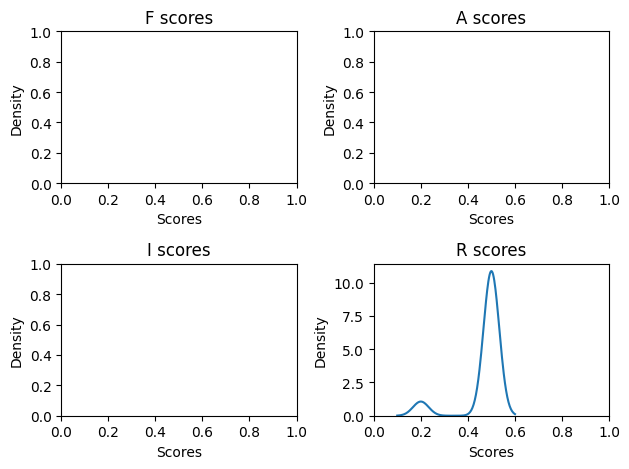

In [6]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for ax, indicator in zip(axes, indicators):
    sns.kdeplot(data=df_csdms_github_results, x=indicator, ax=ax, warn_singular=False)
    ax.set_title(f'{indicator} scores')
    ax.set_xlabel('Scores')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

Lastly, we can report out the pass/fail results of the low level indicators (e.g. F1.2) for further inspection.

In [7]:
for indicator in indicators_low:
    # number of models that passed for given low level indicator
    num_pass = df_csdms_github_results[df_csdms_github_results[indicator] == 1].shape[0]
    # number of models that failed for given low level indicator
    num_fail = df_csdms_github_results[df_csdms_github_results[indicator] == 0].shape[0]
    # total number of models evaluated for given low level indicator, models not evaluated have blank entries
    num_total = num_pass + num_fail
    print('%s: %i models passed out of %i evaluated (%.1f%%)' % (indicator,num_pass,num_total,100*num_pass/num_total))

F1_1: 112 models passed out of 112 evaluated (100.0%)
F1_2: 0 models passed out of 112 evaluated (0.0%)
F2_1: 112 models passed out of 112 evaluated (100.0%)
F2_2: 0 models passed out of 112 evaluated (0.0%)
F3_1: 0 models passed out of 112 evaluated (0.0%)
F3_2: 112 models passed out of 112 evaluated (100.0%)
F3_3: 0 models passed out of 112 evaluated (0.0%)
A1_2: 0 models passed out of 112 evaluated (0.0%)
A1_3: 0 models passed out of 112 evaluated (0.0%)
A1_3: 0 models passed out of 112 evaluated (0.0%)
A1_4: 0 models passed out of 112 evaluated (0.0%)
A1_5: 0 models passed out of 112 evaluated (0.0%)
A3_2: 0 models passed out of 112 evaluated (0.0%)
A3_3: 0 models passed out of 112 evaluated (0.0%)
A3_4: 0 models passed out of 112 evaluated (0.0%)
A3_5: 0 models passed out of 112 evaluated (0.0%)
I1_1: 0 models passed out of 112 evaluated (0.0%)
I1_3: 0 models passed out of 112 evaluated (0.0%)
I1_4: 0 models passed out of 112 evaluated (0.0%)
I2_1: 0 models passed out of 112 evalu